
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [24]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np

In [25]:
# Loading in the heart disease data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [26]:
# Changing variable data types
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

In [27]:
# Classifying predictor vs explanatory variables
X = ha.drop(["cp"], axis = 1)
y = ha["cp"]

# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [28]:
# kNN Model column transformer
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [29]:
# Creating the pipeline
knn_pipe = Pipeline(
  [
      ("preprocessing", ct),
      ("knn", KNeighborsClassifier())]
)

# Optimal K with corresponding values
knn_grid = {'knn__n_neighbors': [1,3,5,10,15,20,25,30,35,40,50]}

knn_gscv = GridSearchCV(knn_pipe, knn_grid, cv = 5, scoring='accuracy')
knn_gscv_fitted = knn_gscv.fit(X, y)
pd.DataFrame(data = {
    "neighbors": knn_grid['knn__n_neighbors'],
    "scores": knn_gscv_fitted.cv_results_['mean_test_score']})

,neighbors,scores
0,1,0.421684
1,3,0.469293
2,5,0.472795
3,10,0.523973
4,15,0.523771
5,20,0.542155
6,25,0.560471
7,30,0.538451
8,35,0.534882
9,40,0.527609


In [30]:
# Optimal k value
knn_optimal = Pipeline(
    [
        ('preprocessing', ct),
        ('knn_optimal', KNeighborsClassifier(n_neighbors = 35))
    ]
)

# Fitting to our data
knn_optimal_fit = knn_optimal.fit(X,y)
knn_optimal_fit.score(X_test, y_test)

0.5362318840579711

In [31]:
# Decision Tree model
dt_pipe = Pipeline(
    [
        ('preprocessing', ct),
        ('Decision_tree', DecisionTreeClassifier())
    ]
)

# Optimal leafs with corresponding values
dt_grid = {'Decision_tree__min_samples_leaf': [1,3,5,10,15,20,25,30,35,40,50]}

dt_gscv = GridSearchCV(dt_pipe, dt_grid, cv = 5, scoring='accuracy')
dt_gscv_fitted = dt_gscv.fit(X, y)
pd.DataFrame(data = {
    "neighbors": dt_grid['Decision_tree__min_samples_leaf'],
    "scores": dt_gscv_fitted.cv_results_['mean_test_score']})

,neighbors,scores
0,1,0.384781
1,3,0.410236
2,5,0.432458
3,10,0.465791
4,15,0.516700
5,20,0.505657
6,25,0.534747
7,30,0.538586
8,35,0.552997
9,40,0.552997


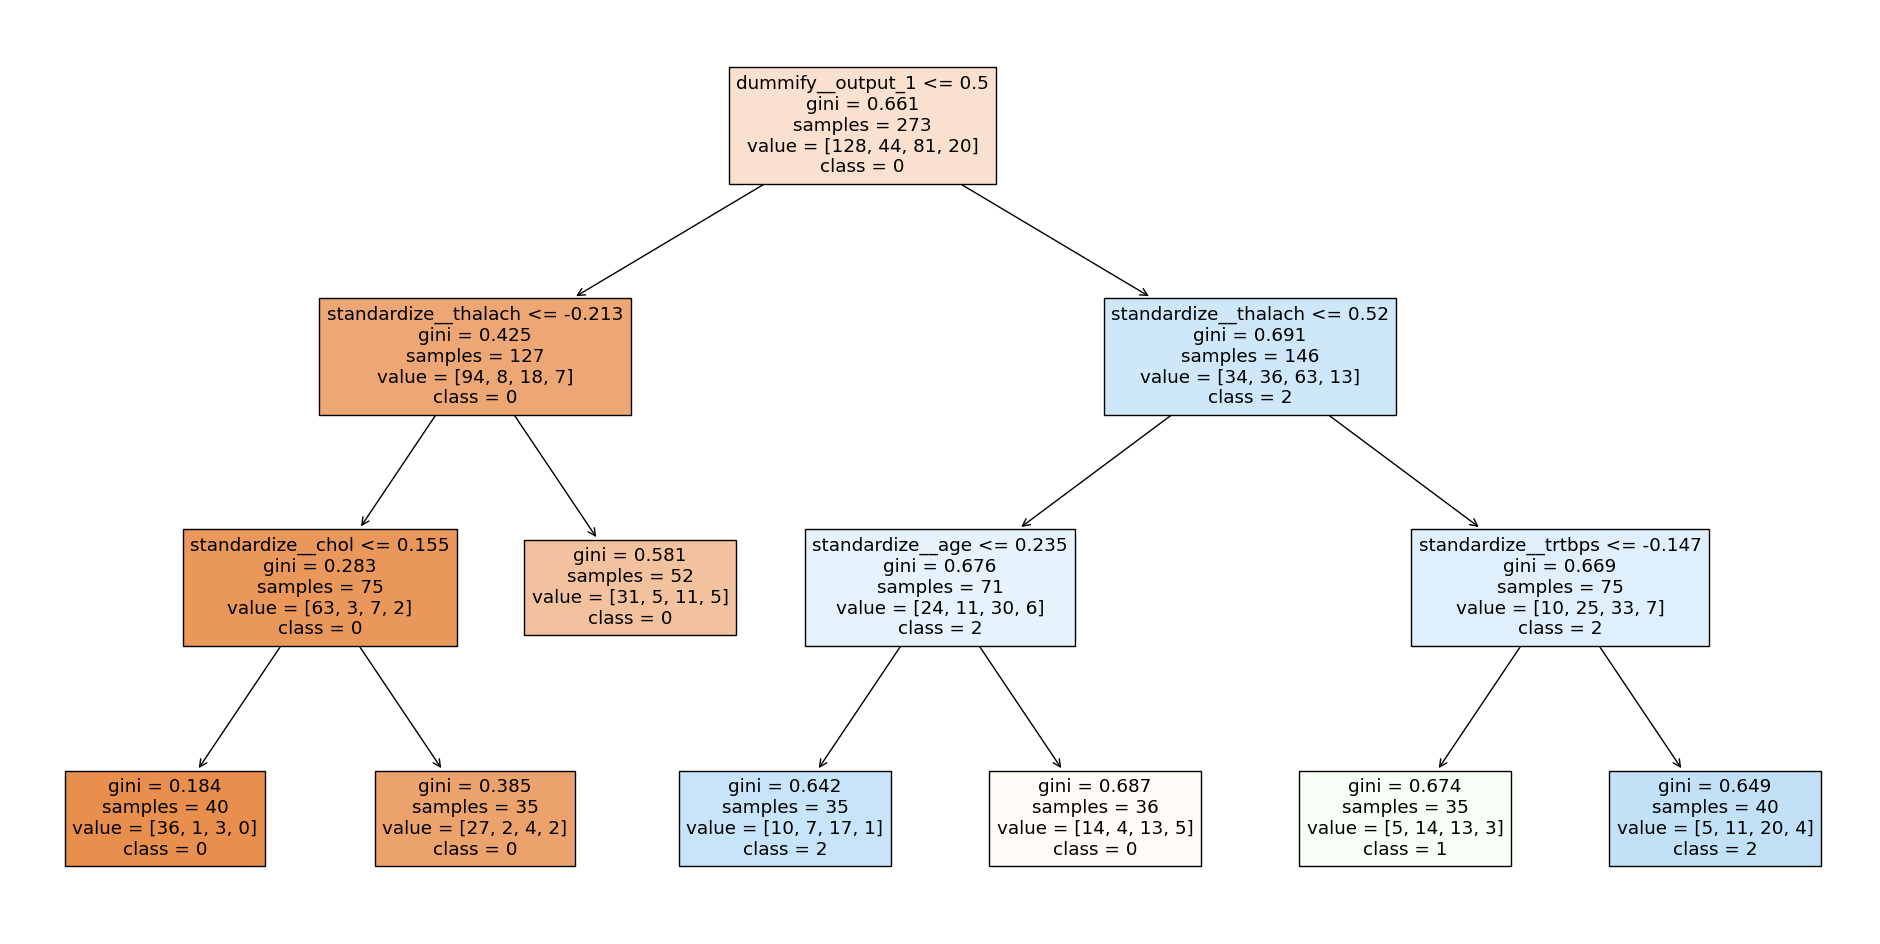

In [32]:
# Optimal leaf value pipeline
dt_optimal = Pipeline(
    [
        ('preprocessing', ct),
        ('dt_optimal', DecisionTreeClassifier(min_samples_leaf = 35))
    ]
)

# Fitting the model to our data
dt_optimal_fit = dt_optimal.fit(X,y)


plt.figure(figsize=(24, 12))  # Set the figure size

plot_tree(dt_optimal.named_steps['dt_optimal'],
          feature_names=ct.get_feature_names_out(X.columns.tolist()).tolist(),
          class_names=['0', '1', '2', '3'],
          filled=True)
plt.show()

In [33]:
dt_optimal_fit.score(X, y)

0.5824175824175825

In [34]:
# LDA Model
lda_pipe = Pipeline(
  [
      ("preprocessing", ct),
      ("lda", LinearDiscriminantAnalysis())]
)

# Fit model to our data
lda_pipe_fit = lda_pipe.fit(X,y)
lda_pipe_fit.score(X, y)

0.5714285714285714

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [37]:
# CP = 3
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)


dummies = pd.get_dummies(ha['cp'])
ha["cp_is_3"] = dummies["3"].astype(str)

X = ha.drop(["cp_is_3", 'cp'], axis = 1)
y = ha["cp_is_3"]

log_Pipe = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = log_Pipe.fit(X,y)
y_pred = log_Pipe.predict(X_test)
f1_score(y_test, y_pred, average = "micro")

0.42028985507246375

In [39]:
# CP = 1
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

dummies = pd.get_dummies(ha['cp'])
ha["cp_is_1"] = dummies["1"].astype(str)

X = ha.drop(["cp", "cp_is_1"], axis = 1)
y = ha["cp_is_1"]

log_pipeline_fitted = log_Pipe.fit(X,y)
y_pred = log_Pipe.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.42028985507246375

In [40]:
# CP = 0
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

dummies = pd.get_dummies(ha['cp'])
ha["cp_is_0"] = dummies["0"].astype(str)

X = ha.drop(["cp_is_0", 'cp'], axis = 1)
y = ha["cp_is_0"]

log_pipeline_fitted = log_Pipe.fit(X,y)
y_pred = log_Pipe.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.17391304347826086

In [41]:
# CP = 2
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

dummies = pd.get_dummies(ha['cp'])
ha["cp_is_2"] = dummies["2"].astype(str)

X = ha.drop(["cp", "cp_is_2"], axis = 1)
y = ha["cp_is_2"]

log_pipeline_fitted = log_Pipe.fit(X,y)
y_pred = log_Pipe.predict(X_test)
f1_score(y_test, y_pred, average='micro')

0.42028985507246375

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [45]:
# 0 vs 1
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

ha_new = ha[(ha["cp"] == "0") | (ha["cp"] == "1")]

X = ha_new.drop(["cp"], axis = 1)
y = ha_new["cp"]

logistic_model_fitted = log_Pipe.fit(X,y)

# ROC and AUC
y_prob = log_Pipe.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8442826704545455

In [46]:
# 0 vs 2
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

ha_2 = ha[(ha["cp"] == "0") | (ha["cp"] == "2")]

X = ha_2.drop(["cp"], axis = 1)
y = ha_2["cp"]

logistic_model_fitted = log_Pipe.fit(X,y)

# ROC and AUC
y_prob = log_Pipe.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8080632716049382

In [47]:
# 0 vs 3
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha['sex'] = ha['sex'].astype(str)
ha['cp'] = ha['cp'].astype(str)
ha['restecg'] = ha['restecg'].astype(str)
ha['output'] = ha['output'].astype(str)

ha_3 = ha[(ha["cp"] == "0") | (ha["cp"] == "3")]

X = ha_3.drop(["cp"], axis = 1)
y = ha_3["cp"]

logistic_model_fitted = log_Pipe.fit(X,y)

# Final Model ROC AUC metric
y_prob = log_Pipe.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.828125